# Outlook

In this notebook we explain how to combine an AutoReset environment with the use of multiple environments. This notebook mainly contains text and figures for explanations, it is complementary to notebook dedicated to experimentation. Nevertheless, we urge you to read it carefully, it contains crucial informations to understand the inner working of BBRL.

## Multiple environments and AutoReset 

One efficient way to accelerate and improve the stability of RL is to let agents collect data in several environments at the same time. This can be done with a multiprocessing approach, a topic that we will cover later, but this can also be done within a single process approach.

The basic idea is that, instead of interacting with a single environment, the agent can interact with a vector of environments, receiving a vector of observations and rewards and sending a vector of actions. This looks the same as performing a loop of interactions over single environments, but this can be computed faster just by leveraging the capability of python to deal efficiently with large vectors and matrices, particularly when using a GPU to perform the computation.

However, such use of parallel environments raises specific issues that are not so easy to deal with. This is what we cover in this colab.

The main issue is that it is often the case that different episodes in the same environment do not last the same number of time steps. For instance, in the CartPole environment, the goal is to keep a pole up as long as possible, so the episode of a failing agent may last only a few steps (the minimum is 8) whereas a successful agent may keep it up until a predetermined time limit, e.g. 500 times steps.

So, if the agent is collecting data in parallel from a vector of environments, what should it do? If it performs just one episode at a time for all environments, some environments will stop earlier than others and data collection with these environment will be staled until the last environment stops. We will see contexts where it is appropriate to do this (e.g. for statistically evaluating agents) but, in most contexts, one can see this as a waste of time.

The other option consists in collecting data for a fixed number of steps `n_steps`, rather than a number of episodes and restarting (resetting) each environment each time it stops, until `n_steps` is reached. This way, there is no waste of time. This is what [the AutoResetGymAgent](https://github.com/osigaud/bbrl/blob/master/bbrl/agents/gymb.py#L300) is designed for. 

Collecting data for `n_steps` offers the possibility to process this data (e.g. training the RL agent from this data) and to go back to data collection until a more global stopping criterion is reached. The `n_steps` data collection part is called an `epoch`.



The `n_steps` data collection model faces the following list of issues: 
- In many cases, the end of an epoch does not coincide with the end of an episode. When an epochs ends before an episode stops, a specific treatment is needed to avoid loosing data from an epoch to the next
- Data from an epoch may contain several successive episodes, and the transition from an episode to the next should not be considered as a training transition, it must be properly ignored by the training process
- Besides, an episode may stop either because the corresponding task is done, or because a time limit has been reached. This also requires a specific treatment.

## Binding together data collection epochs from the same episode

When moving from a data collection epoch to the next, the transition from the last state of the previous epoch to the first state of the next epoch should not be ignored when processing the data, which is what would happen if we do nothing. This is illustrated below.



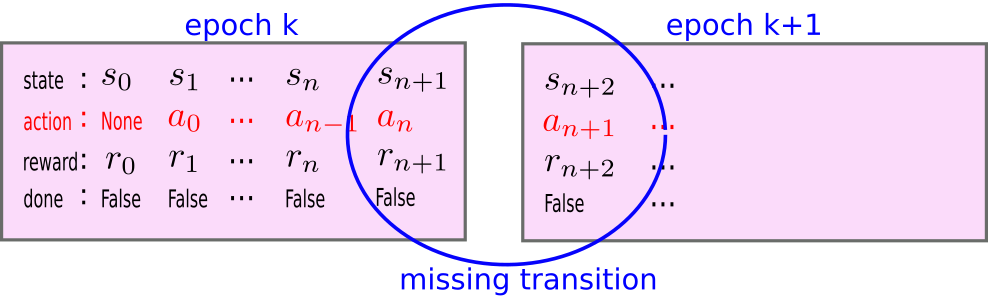

The right way to fix this issue is to copy the last time step frame of the previous epoch into the first time step frame of the next epoch. That way, the potentially missing transition will be present in the first two frames of the second epoch. This is illustrated below.

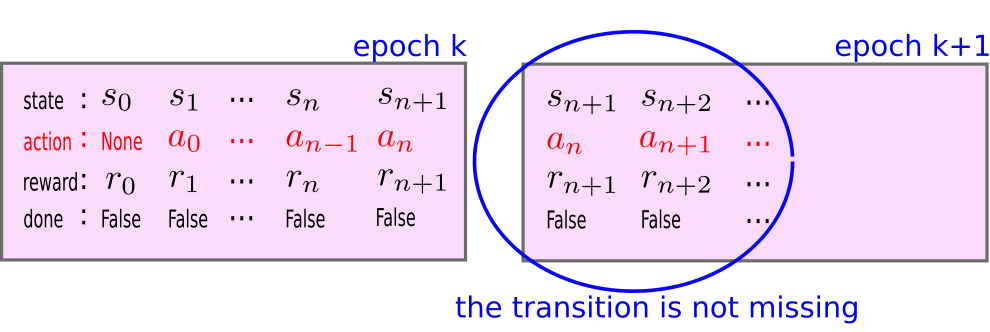

This mechanism is implemented using `train_workspace.copy_n_last_steps(1)` as shown in the piece of code below.

In [ ]:
    for epoch in range(cfg.algorithm.max_epochs):
        if epoch > 0:
            train_workspace.zero_grad()
            train_workspace.copy_n_last_steps(1)
            a2c_agent(train_workspace, t=1, n_steps=cfg.algorithm.n_steps - 1, stochastic=True)
        else:
            a2c_agent(train_workspace, t=0, n_steps=cfg.algorithm.n_steps, stochastic=True)

Note that `train_workspace.zero_grad()` is used to clean all gradients in the workspace before processing the new data that will be collected.

## Dealing with transitions from one episode to the next

A second issue arises when the AutoReset mechanism switches from episode $k$ to episode $k+1$ inside an epoch. The transition from the last step of episode $k$ to the first step of episode $k+1$ should be ignored, as it does not truly correspond to a step of the agent.

If we apply the SaLinA code for the Bellman backup shown above as is, the transition between episodes is not ignored, though it should.

The appropriate way to deal with this difficulty consists in replacing single step informations with transition informations, and removing the transitions whose first step is the end of an episode and whose second step is the beginning of the second episode.

In practice, the sequence of steps built in the workspace is duplicated to constitute a sequence of pairs, as illustrated below. All informations of each step are duplicated: the state, the reward, whether the task is done, whether it is truncated, the current time step and the cumulated reward, writing $step_i = <s_i, a_i, done_i, truncated_i, ...>$.

Then all the transitions where the first step is done are removed. In the example below, the transition $[step_2, step_3]$ is removed because it verifies this condition, resulting in the final list. 

Fortunately, because of the duplication, all step informations are still there (in the final list you find from $step_0$ to $step_4$), thus we can find the end of episodes by looking at the value of `done` and `truncated` in the second part of the pairs.

\begin{equation*}
\begin{bmatrix}
           \text{step}_{0} \\
           \text{step}_{1}\\
           \text{step}_{2}\\
           \text{step}_{3} \\
\text{step}_{4} \\
         \end{bmatrix}
     => \begin{bmatrix}
           \text{step}_{0},\text{step}_{1} \\
           \text{step}_{1},\text{step}_{2} \\
           \text{step}_{2},\text{step}_{3} \\
           \text{step}_{3},\text{step}_{4} \\
         \end{bmatrix}
=> \begin{bmatrix}
           \text{step}_{0},\text{step}_{1} \\
           \text{step}_{1},\text{step}_{2} \\
           \text{step}_{3},\text{step}_{4} \\
         \end{bmatrix}
  \end{equation*}

The function which performs this reorganization and filtering of transitions is [the get_transition() function in the Workspace class](https://github.com/osigaud/bbrl/blob/master/bbrl/workspace.py#L656-L681).

Given the organization into pairs of step informations, the way to access data is a little different. To know whether an episode is done or truncated, the information is in the second part of the pair, so one should use `done[1]` or `truncated[1]`. And to get $V(s_{t+1})$, one should use `critic[1]`. By contrast, to get the reward or the value of the critic at the current state, one should use `reward[0]` or `critic[0]`.

By chance, given that the pairs have two elements, `reward[0]` is equivalent to `reward[:-1]`  and `critic[1]` is equivalent to `critic[1:]` (all rewards but the last), thus it happens that for temporal difference updates, the code is equivalent to the previous version, considering the shifted reward information ($r_t$ instead of $r_{t+1}$).

With the previous version, `reward[:-1]` was meaning all rewards but the last, now it means all rewards in the first element of the pairs, and the same for `critic[1:]`.

## What's next?

In [this notebook](https://colab.research.google.com/drive/1yAQlrShysj4Q9EBpYM8pBsp2aXInhP7x?usp=sharing), we leverage all the above information to write a first simple implementation of the A2C algorithm.

In [this other notebook](https://colab.research.google.com/drive/1H9_gkenmb_APnbygme1oEdhqMLSDc_bM?usp=sharing), we do the same for DQN.